# Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

# Importing Required Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from timm.models.layers import trunc_normal_, DropPath
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Cloning Git Repository

In [4]:
! git clone https://github.com/prathamadh/Depth-Map.git

Cloning into 'Depth-Map'...
remote: Enumerating objects: 670, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 670 (delta 0), reused 0 (delta 0), pack-reused 669 (from 1)
Receiving objects: 100% (670/670), 956.44 MiB | 33.73 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Updating files: 100% (341/341), done.


---

# Model Setup and Loading Checkpoints

In [5]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
    super(DoubleConv, self).__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(inplace = True)
    )

  def forward(self, x):
    return self.conv_op(x)

In [6]:
class UpSample(nn.Module):
    def __init__(self, in_channels, concat_channels, out_channels, kernel_size, stride ,padding, output_padding = 0):
        super(UpSample, self).__init__()

        # Deconvolutional layers
        self.up = nn.ConvTranspose2d(in_channels, concat_channels, kernel_size, stride, padding, output_padding)
        self.conv = DoubleConv(concat_channels, out_channels)

    def forward(self, x1):
        x1 = self.up(x1)
        x1 = self.conv(x1)
        return x1

In [7]:
class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

In [8]:
class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, out_chans=1,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 **kwargs,):

        super().__init__()



        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )


        self.downsample_layers.append(stem)


        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)


        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks


        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]


        cur = 0


        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )


            self.stages.append(stage)

            cur += depths[i]



        # Output head for roughness map prediction
        # Upconvolutions
        self.upconvolution_1 = UpSample(dims[-1], dims[-1] // 2, dims[-1] // 4, kernel_size= 4, stride=2, padding = 1, output_padding = 1)
        self.upconvolution_2 = UpSample(dims[-2], dims[-2] // 2, dims[-2] // 4, kernel_size= 2, stride=2, padding = 0)
        self.upconvolution_3 = UpSample(dims[-3], dims[-3] // 2, dims[-3] // 4, kernel_size= 2, stride=2, padding = 0)
        self.upconvolution_4 = UpSample(dims[-4], dims[-4] // 2, dims[-4] // 4, kernel_size= 2, stride=2, padding = 0)



        # Pixel Shuffles
        self.pixel_shuffle_1 = nn.PixelShuffle(2)
        self.pixel_shuffle_2 = nn.PixelShuffle(2)
        self.pixel_shuffle_3 = nn.PixelShuffle(2)
        self.pixel_shuffle_4 = nn.PixelShuffle(2)


        # Intermediate Upconcolutions
        self.inter_upconv_1_1 = UpSample(dims[-2], dims[-3] , dims[-3], kernel_size=2, stride = 2, padding = 0)
        self.inter_upconv_1_2 = UpSample(dims[-2], dims[-4] , dims[-4], kernel_size=2, stride = 2, padding = 0)
        self.inter_upconv_2_3 = UpSample(dims[-3], dims[-4] , dims[-4], kernel_size=2, stride = 2, padding = 0)
        self.inter_upconv_3_4 = UpSample(dims[-3] , dims[-4], dims[-4], kernel_size=2, stride = 2, padding = 0)


        # Final deconvolution layers
        self.f_pixel_shuffle = nn.PixelShuffle(2)

        # Final Convolutions
        self.f_douconv1 = DoubleConv(64, 32)
        self.f_douconv2 = DoubleConv(32, 16)
        self.f_douconv3 = DoubleConv(16, 8)
        self.f_douconv4 = DoubleConv(8, 4)
        self.f_douconv5 = DoubleConv(4, 2)
        self.f_douconv6 = DoubleConv(2, 1)



        self.apply(self._init_weights)




    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)





    def forward_features(self, x):
        features = []
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
            features.append(x)




        # Obtaining output from each steps
        stage_1_op = features[0]
        stage_2_op = features[1]
        stage_3_op = features[2]
        stage_4_op = features[3]


        #print('Stage 1 Output Shape:', stage_1_op.shape)
        #print('Stage 2 Output Shape:', stage_2_op.shape)
        #print('Stage 3 Output Shape:', stage_3_op.shape)
        #print('Stage 4 Output Shape:', stage_4_op.shape)



        # Upsampling steps

        # For outputs from stage 4
        a1 = self.pixel_shuffle_1(stage_4_op)
        features.append(a1)

        #print('Stage a1 Output Shape:', features[-1].shape)

        b1 = self.upconvolution_1(stage_4_op)
        features.append(b1)
        #print('Stage b1 Output Shape:', features[-1].shape)


        # Upsample to 37x37 using bilinear interpolation
        a1 = F.interpolate(a1, size=(37, 37), mode='bilinear', align_corners=False)
        features.append(a1)
        #print('Stage a1 Output Shape after interpolation:', features[-1].shape)

        ab1 = torch.cat((a1,b1), dim = 1)
        features.append(ab1)
        #print('Stage ab1 Output Shape:', features[-1].shape)

        ab1 = self.inter_upconv_1_1(ab1)
        features.append(ab1)
        #print('Stage ab1 Output Shape:', features[-1].shape)



        # For outputs from stage 3
        a2 = self.pixel_shuffle_2(stage_3_op)
        features.append(a2)
        #print('Stage a2 Output Shape:', features[-1].shape)

        b2 = self.upconvolution_2(stage_3_op)
        features.append(b2)
        #print('Stage b2 Output Shape:', features[-1].shape)

        ab2 = torch.cat((a2,b2), dim = 1)
        features.append(ab2)
        #print('Stage ab2 Output Shape:', features[-1].shape)


        ab12 = torch.cat((ab1, ab2), dim = 1)
        features.append(ab12)
        #print('Stage ab12 Output Shape:', features[-1].shape)


        ab12 = self.inter_upconv_1_2(ab12)
        features.append(ab12)
        #print('Stage ab12 Output Shape:', features[-1].shape)

        # Upsample to 37x37 using bilinear interpolation
        ab12 = F.interpolate(ab12, size=(150, 150), mode='bilinear', align_corners=False)
        features.append(ab12)
        #print('Stage ab12 Output Shape after interpolation:', features[-1].shape)



        # For outputs from stage 2
        a3 = self.pixel_shuffle_3(stage_2_op)
        features.append(a3)
        #print('Stage a3 Output Shape:', features[-1].shape)

        b3 = self.upconvolution_3(stage_2_op)
        features.append(b3)
        #print('Stage b3 Output Shape:', features[-1].shape)


        ab3 = torch.cat((a3,b3), dim = 1)
        features.append(ab3)
        #print('Stage ab3 Output Shape:', features[-1].shape)



        ab3_12 = torch.cat((ab3, ab12), dim = 1)
        features.append(ab3_12)
        #print('Stage ab3_12 Output Shape:', features[-1].shape)


        ab3_12 = self.inter_upconv_2_3(ab3_12)
        features.append(ab3_12)
        #print('Stage ab3_12 Output Shape:', features[-1].shape)




        # For outputs from stage 1
        a4 = self.pixel_shuffle_4(stage_1_op)
        features.append(a4)
        #print('Stage a4 Output Shape:', features[-1].shape)

        b4 = self.upconvolution_4(stage_1_op)
        features.append(b4)
        #print('Stage b4 Output Shape:', features[-1].shape)

        ab4 = torch.cat((a4,b4), dim = 1)
        features.append(ab4)
        #print('Stage ab4 Output Shape:', features[-1].shape)

        ab4_3_12 = torch.cat((ab4, ab3_12), dim = 1)
        features.append(ab4_3_12)
        #print('Stage ab4_3_12 Output Shape:', features[-1].shape)


        ab4_3_12 = torch.cat((ab4, ab4_3_12), dim = 1)
        features.append(ab4_3_12)
        #print('Stage ab4_3_12 Output Shape:', features[-1].shape)


        # Final deconvolution layer
        f_ps_1 = self.f_pixel_shuffle(ab4_3_12)
        features.append(f_ps_1)
        #print('Stage f_ps_1 Output Shape:', features[-1].shape)

        f_doucov_1 = self.f_douconv1(f_ps_1)
        features.append(f_doucov_1)
        #print('Stage f_doucov_1 Output Shape:', features[-1].shape)

        f_doucov_2 = self.f_douconv2(f_doucov_1)
        features.append(f_doucov_2)
        #print('Stage f_doucov_2 Output Shape:', features[-1].shape)


        f_doucov_3 = self.f_douconv3(f_doucov_2)
        features.append(f_doucov_3)
        #print('Stage f_doucov_3 Output Shape:', features[-1].shape)

        f_doucov_4 = self.f_douconv4(f_doucov_3)
        features.append(f_doucov_4)
        #print('Stage f_doucov_4 Output Shape:', features[-1].shape)

        f_doucov_5 = self.f_douconv5(f_doucov_4)
        features.append(f_doucov_5)
        #print('Stage f_doucov_5 Output Shape:', features[-1].shape)

        f_doucov_6 = self.f_douconv6(f_doucov_5)
        features.append(f_doucov_6)
        #print('Stage f_doucov_6 Output Shape:', features[-1].shape)


        x = f_doucov_6

        features.append(x)
        #print('Final Output Shape:', features[-1].shape)

        return features



    def forward(self, x):
        features = self.forward_features(x)

        return features

In [9]:
class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )


    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]

            return x

In [10]:
model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_tiny_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth",
    "convnext_small_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

In [11]:
def convnext_base(pretrained=True, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    if pretrained:
        # checkpoint = torch.load(kwargs['checkpoint'], map_location="cpu")
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model_dict = model.state_dict()

        # print(model_dict)
        # print(checkpoint)

        pretrained_dict = {}
        unmatched_pretrained_dict = {}

        for k, v in checkpoint['model'].items():
            if k in model_dict.keys():
                pretrained_dict[k] = v
            else:
                unmatched_pretrained_dict[k] = v

        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        print(f'The type of checkpoint is {type(checkpoint)}.')
        print(f'The type of model.state_dict is {type(model.state_dict)}.')
        print(f'The type of model.state_dict() is {type(model.state_dict())}.')

        for name,param in model.named_parameters():
          if name in pretrained_dict.keys():
              param.requires_grad = False
          else :
              param.requires_grad = True




        print('\n')

        print(f'The keys in pretrained_dict are : \n {pretrained_dict.keys()}')

        print('\n')

        print(f'The keys in unmatched_pretrained_dict are : \n {unmatched_pretrained_dict.keys()}')

        print('\n')

        print(
            'Successfully loaded pretrained %d paras, and %d paras are unmatched.'
            %(len(pretrained_dict.keys()), len(unmatched_pretrained_dict.keys())))

        print('\n')

        print('Unmatched pretrained paras are:', unmatched_pretrained_dict.keys())



    return model

---

# Model Instantiation

In [12]:
model = convnext_base(True, in_22k=False).cuda()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth
100%|██████████| 338M/338M [00:01<00:00, 208MB/s]


The type of checkpoint is <class 'dict'>.
The type of model.state_dict is <class 'method'>.
The type of model.state_dict() is <class 'collections.OrderedDict'>.


The keys in pretrained_dict are : 
 dict_keys(['downsample_layers.0.0.weight', 'downsample_layers.0.0.bias', 'downsample_layers.0.1.weight', 'downsample_layers.0.1.bias', 'downsample_layers.1.0.weight', 'downsample_layers.1.0.bias', 'downsample_layers.1.1.weight', 'downsample_layers.1.1.bias', 'downsample_layers.2.0.weight', 'downsample_layers.2.0.bias', 'downsample_layers.2.1.weight', 'downsample_layers.2.1.bias', 'downsample_layers.3.0.weight', 'downsample_layers.3.0.bias', 'downsample_layers.3.1.weight', 'downsample_layers.3.1.bias', 'stages.0.0.gamma', 'stages.0.0.dwconv.weight', 'stages.0.0.dwconv.bias', 'stages.0.0.norm.weight', 'stages.0.0.norm.bias', 'stages.0.0.pwconv1.weight', 'stages.0.0.pwconv1.bias', 'stages.0.0.pwconv2.weight', 'stages.0.0.pwconv2.bias', 'stages.0.1.gamma', 'stages.0.1.dwconv.weight', 'stages.0.

---

# Model Configuration Setup

In [13]:
# Download the model file from Hugging Face Hub
repo_name = "ConvNeXt_with_skip_connections"
downloaded_file = hf_hub_download(
    repo_id=f"prakanda/{repo_name}",  # Replace with your Hugging Face username
    filename="ConvNeXt_with_skip_connections.pth"
)
print(f"Model downloaded from Hugging Face Hub: {downloaded_file}")


# Initialize the model and load the state_dict
model.load_state_dict(torch.load(downloaded_file),strict=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ConvNeXt_with_skip_connections.pth:   0%|          | 0.00/409M [00:00<?, ?B/s]

Model downloaded from Hugging Face Hub: /root/.cache/huggingface/hub/models--prakanda--ConvNeXt_with_skip_connections/snapshots/f987645c61581dd3632458287a3ce9f04236b308/ConvNeXt_with_skip_connections.pth


<ipython-input-13-271392278956>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(downloaded_file),strict=False)


<All keys matched successfully>

---

# Result Visualization

In [14]:
# Define the transformation
transform = transforms.Compose([
        transforms.Resize((600, 600)),  # Resize the image to 224x224
        transforms.ToTensor(),          # Convert the image to a PyTorch tensor (HWC -> CHW, normalized [0, 1])
        transforms.Normalize(           # Normalize the tensor to match typical model expectations
            mean=[0.485, 0.456, 0.406],  # Mean for each channel
            std=[0.229, 0.224, 0.225]    # Standard deviation for each channel
        )
    ])

def path_to_tensor(image):
  image = Image.open(image).convert("RGB")
  tensor_image = transform(image)
  tensor_image = tensor_image.unsqueeze(0)
  return tensor_image

In [15]:
def inference(path):
    input_tensor=path_to_tensor(path)
    input_tensor = input_tensor.to("cuda")

    # Example size, adjust as needed
    dic={"input":input_tensor}

    # Pass the tensor through the model
    model.to("cuda")
    with torch.no_grad():  # No gradient calculation for evaluation/testing
        output = model(dic["input"])
        return output[-1]

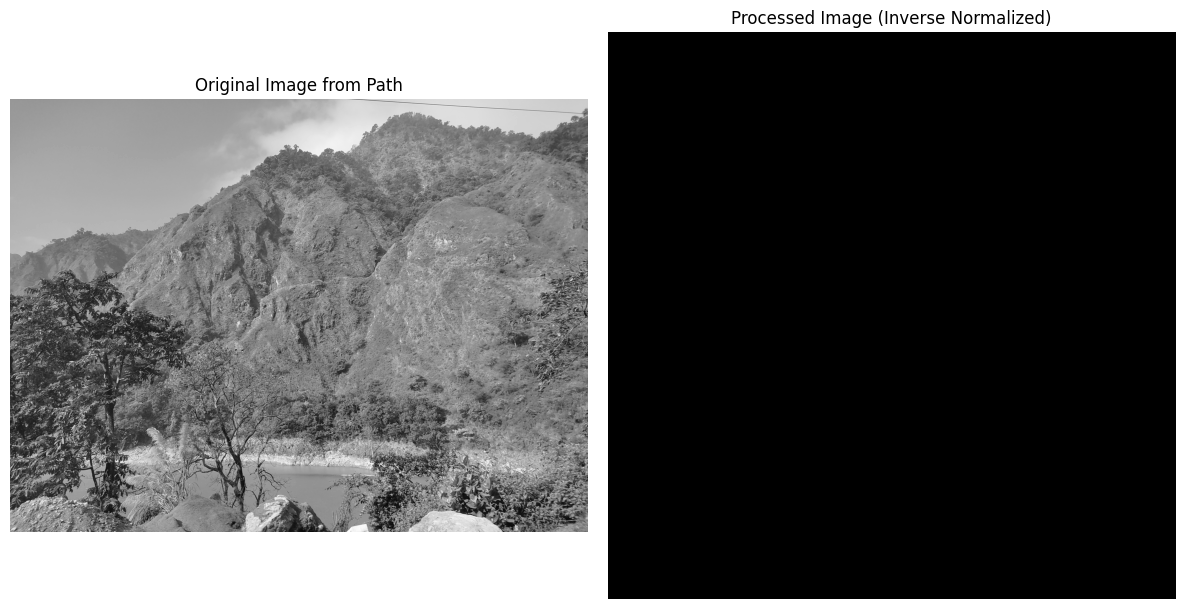

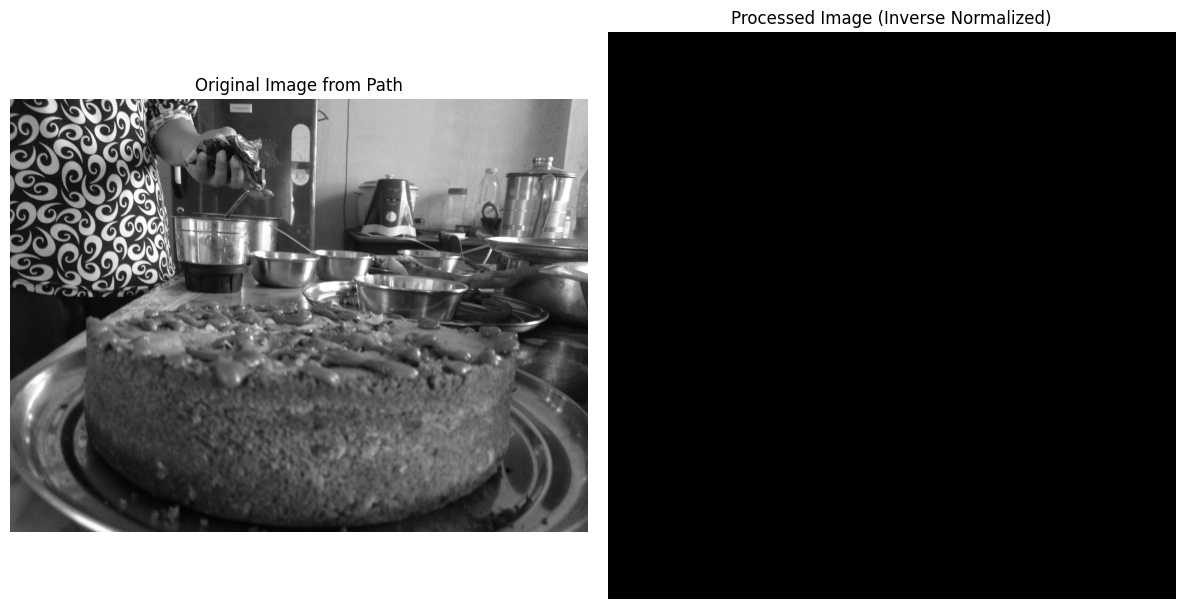

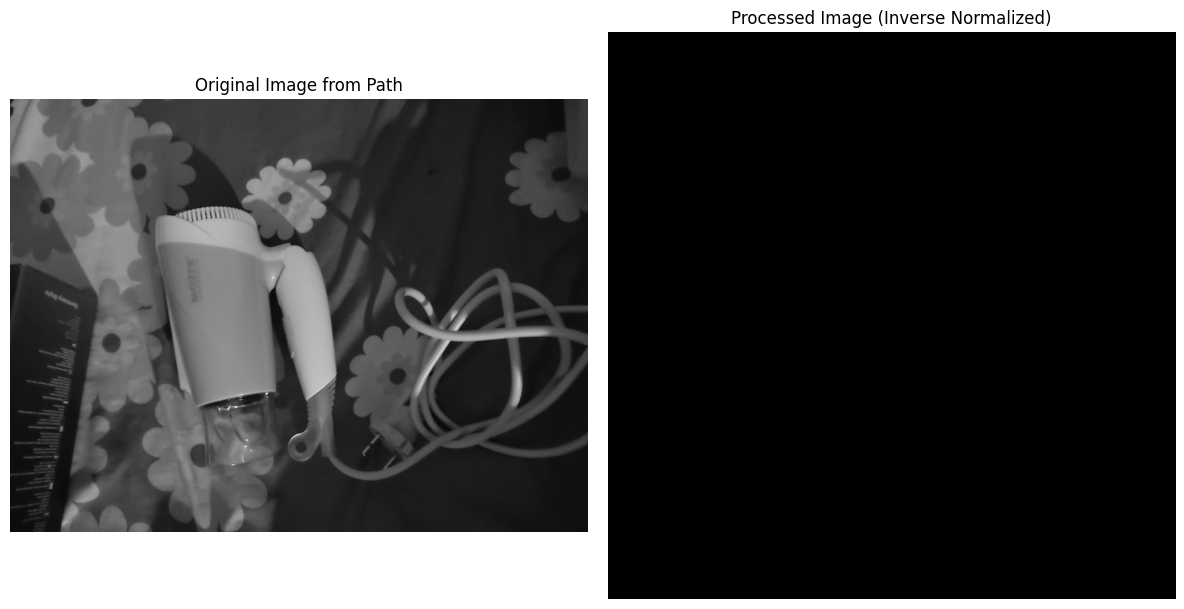

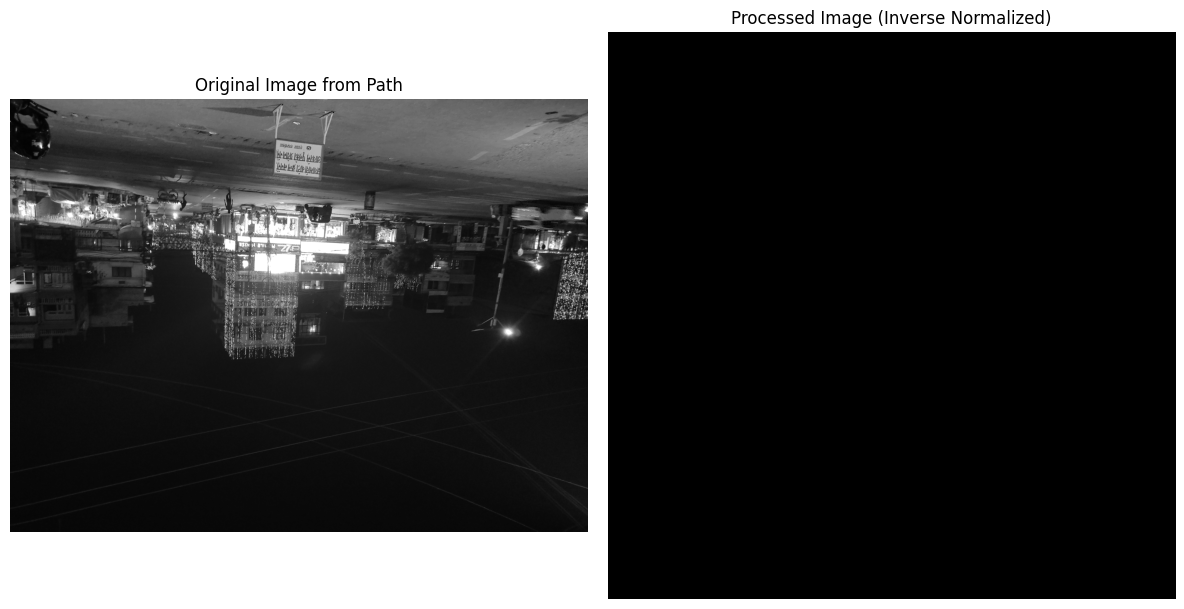

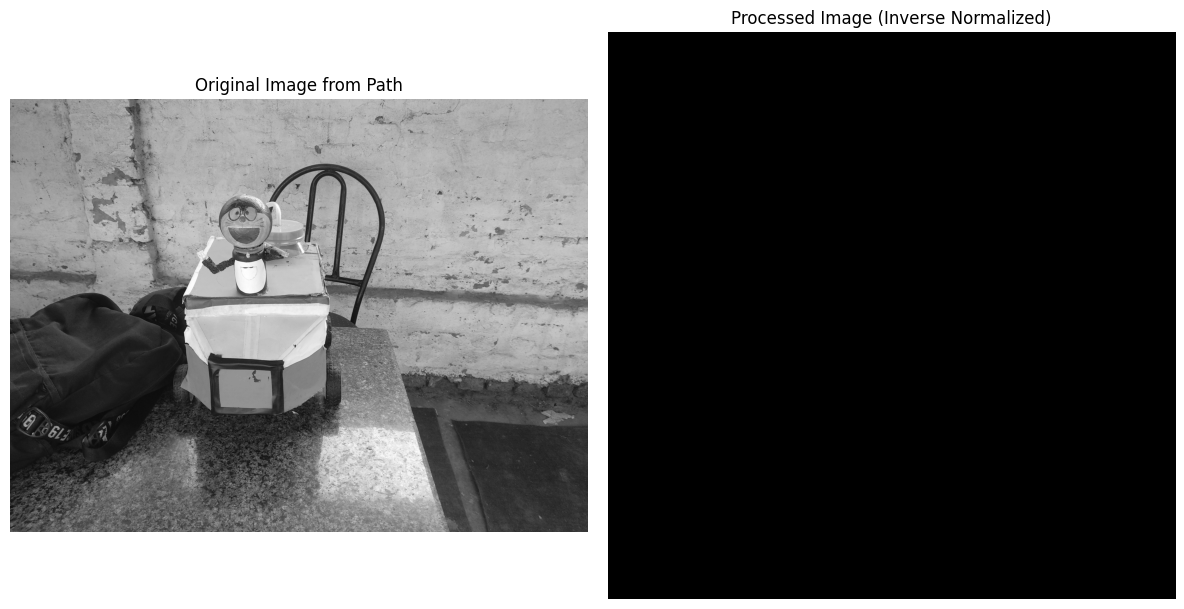

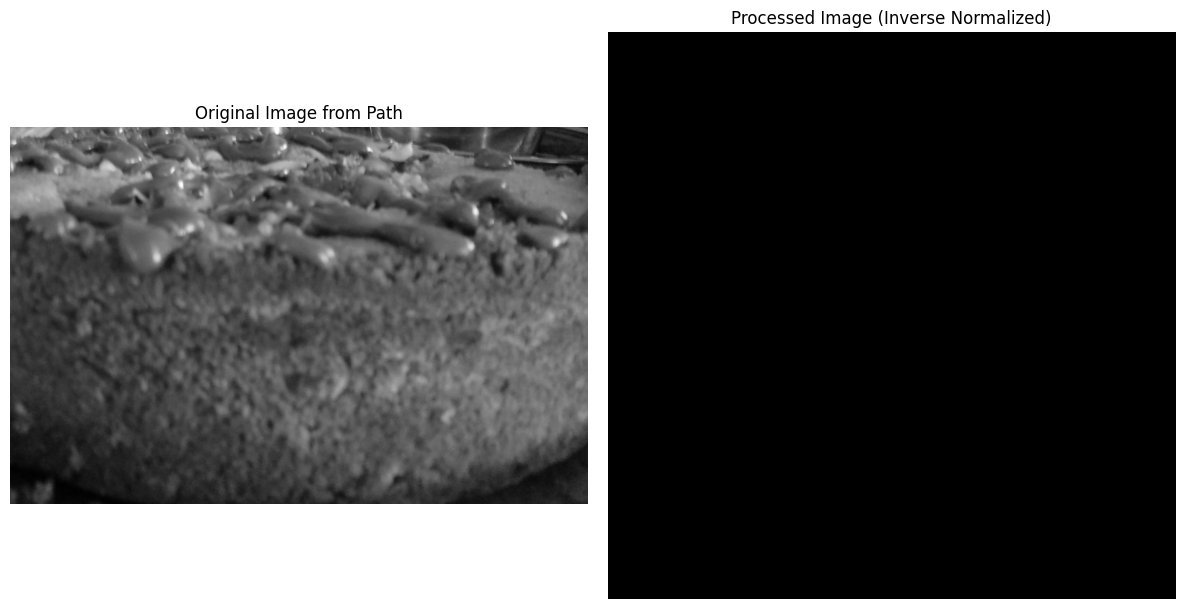

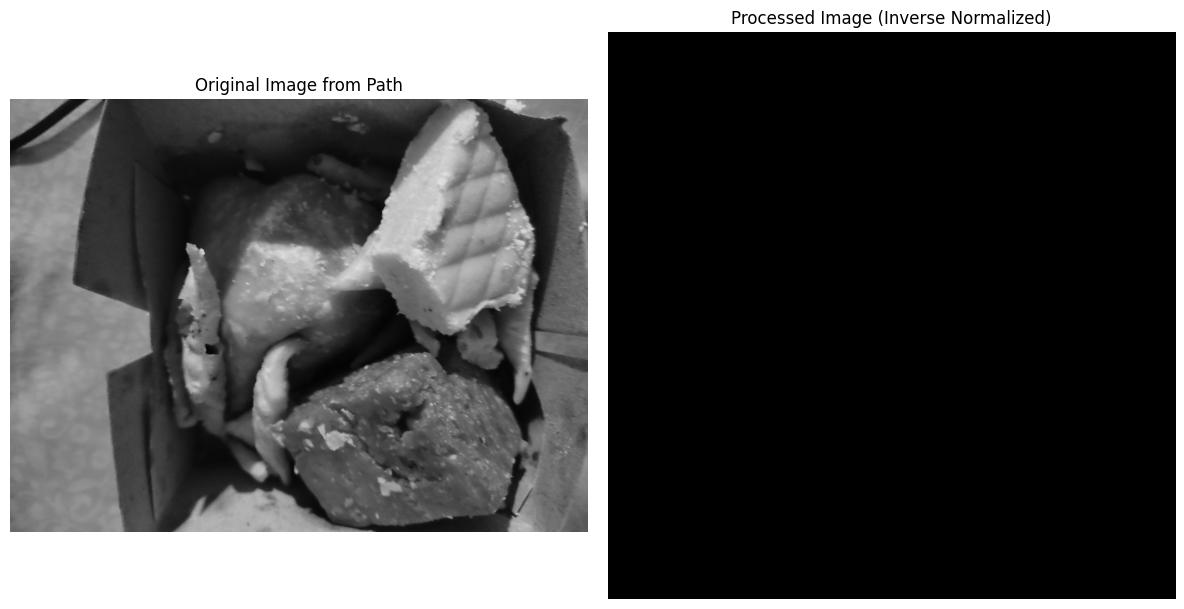

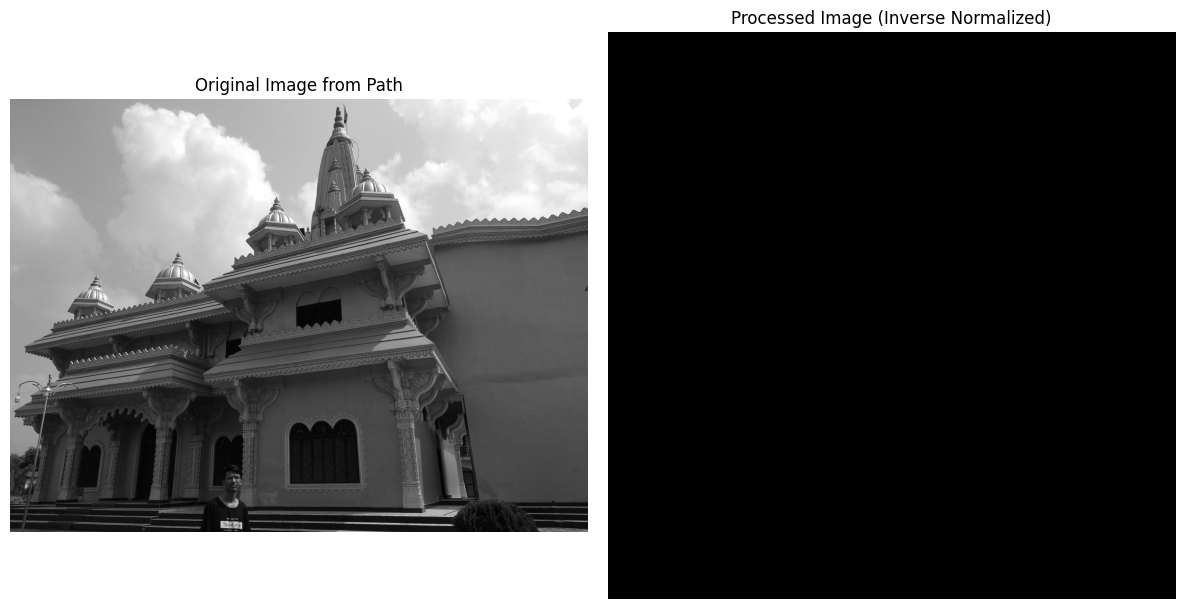

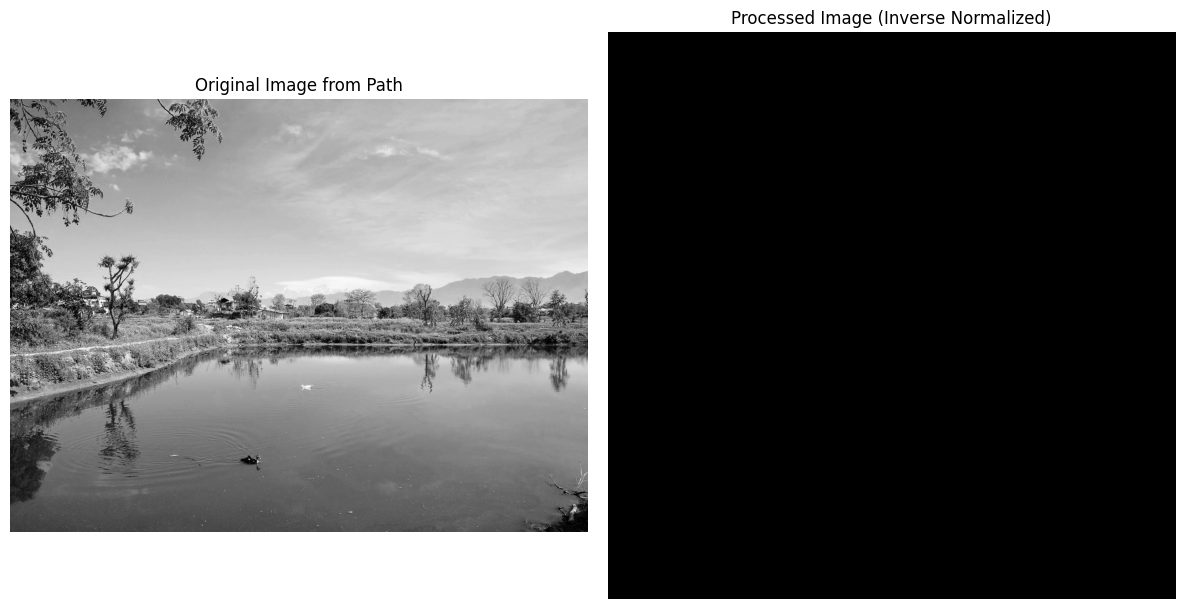

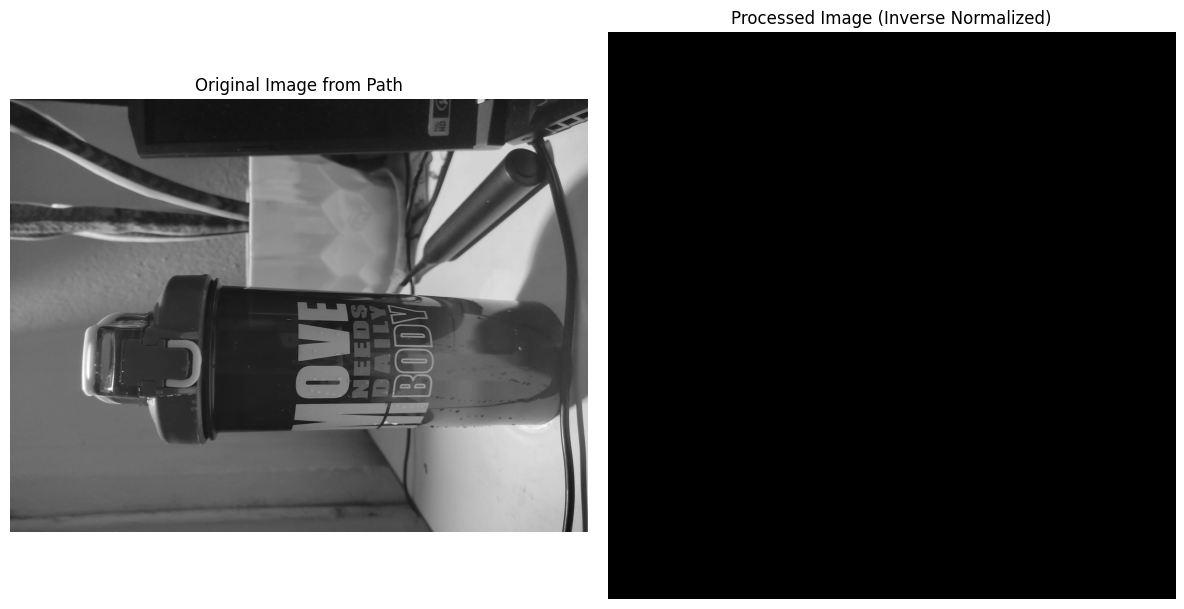

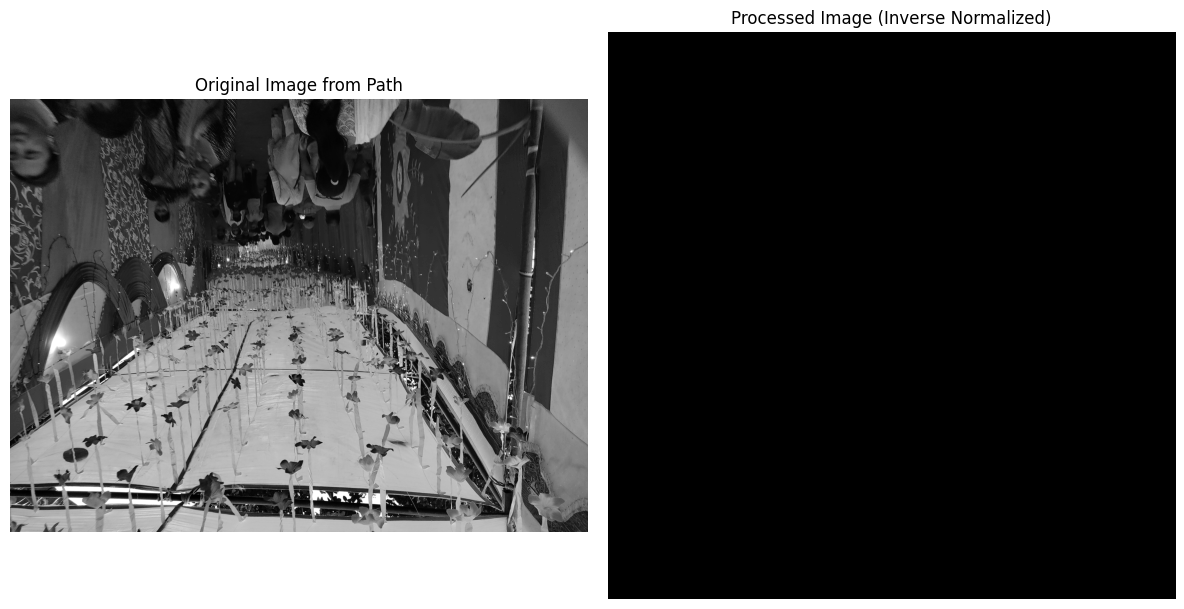

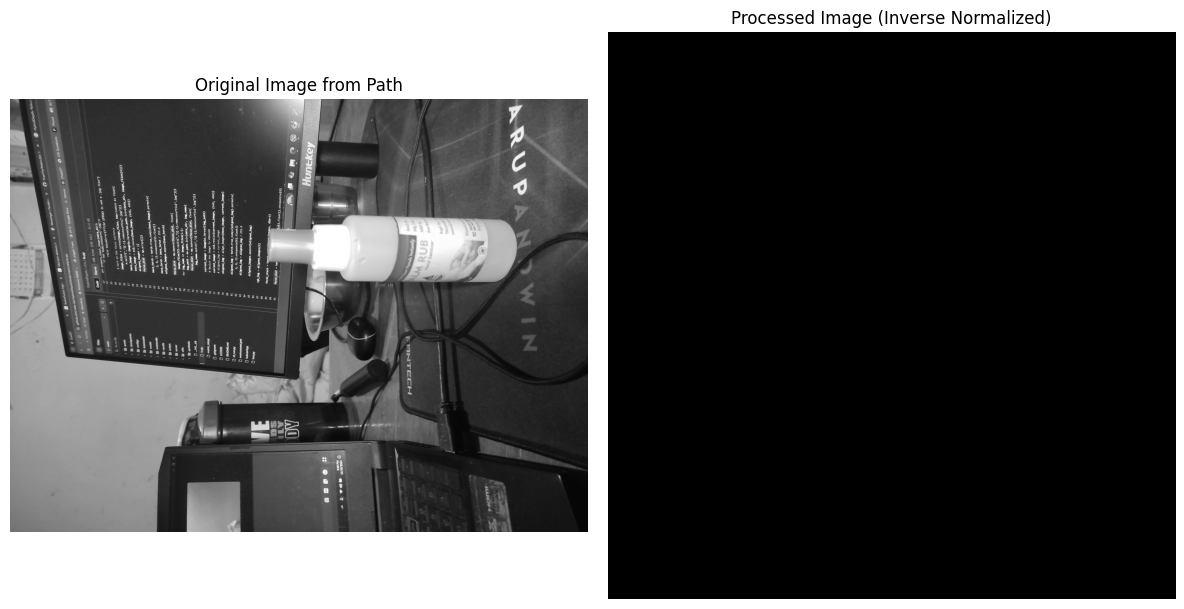

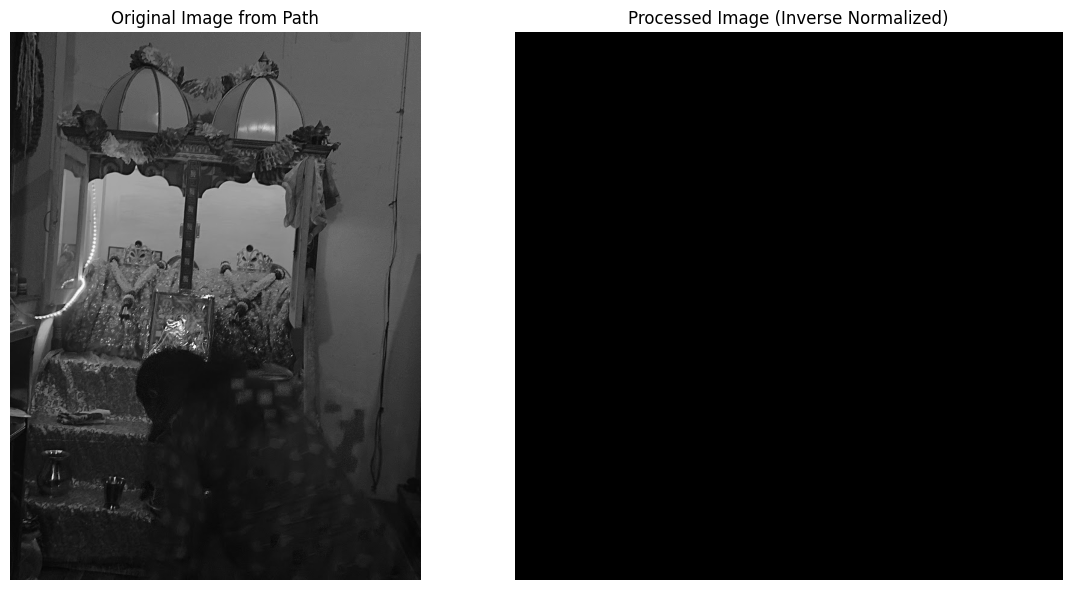

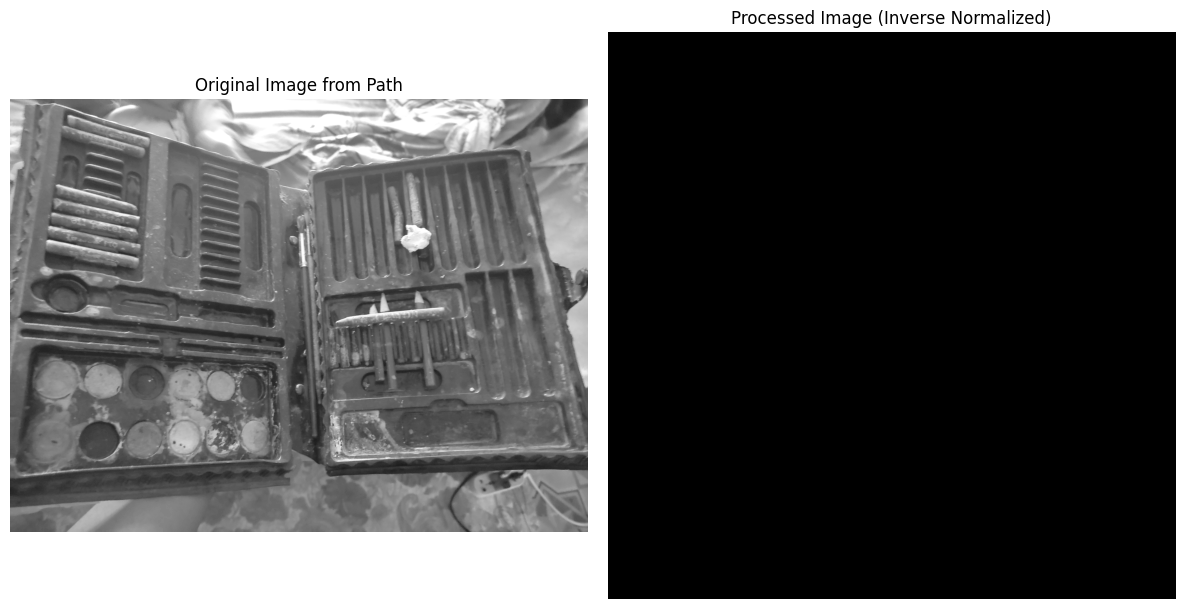

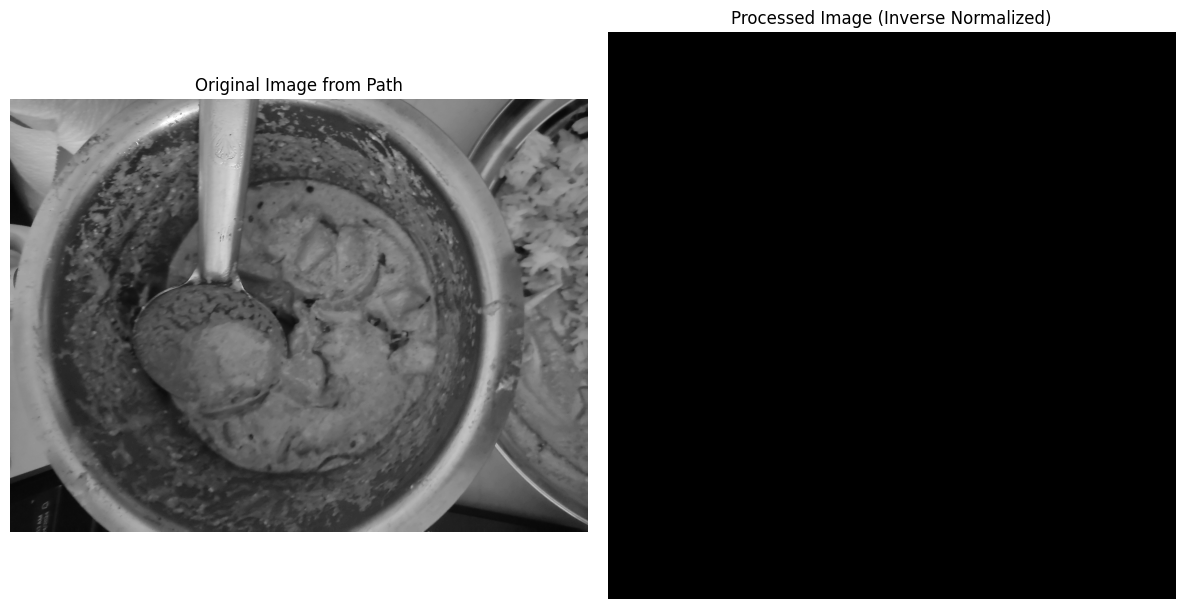

In [16]:
filenames=glob("/content/Depth-Map/samples/test_set/*.jpg")

# Inverse transform function
def inverse_normalize(tensor, mean, std):
        mean = torch.tensor(mean)
        std = torch.tensor(std)
        return tensor * std + mean

# Assuming filenames is a list of file paths
for filepath in filenames:
    output = inference(filepath)
    image = output.to("cpu")

    # Squeeze batch and channel dimensions, then convert to numpy array
    normalized_image = image.squeeze(0).squeeze(0).numpy()
    #normalized_image = np.clip(normalized_image, 0, 1)

    # Load the original image from the file path
    original_image_path = Image.open(filepath).convert("L")  # Convert to grayscale for consistency
    original_image_path = np.array(original_image_path) / 255.0  # Normalize to [0, 1]

    # Create a subplot with 2 images
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image (from the file)
    axs[0].imshow(original_image_path, cmap='gray')
    axs[0].set_title("Original Image from Path")
    axs[0].axis('off')  # Hide axes for better visualization

    # Plot the processed image (inverse normalized)
    axs[1].imshow(normalized_image, cmap='gray')
    axs[1].set_title("Processed Image (Inverse Normalized)")
    axs[1].axis('off')  # Hide axes for better visualization

    # Display the plot
    plt.tight_layout()
    plt.show()